In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TIME_STEP = 10      # rnn time step
INPUT_SIZE = 1      # rnn input size
LR = 0.02           # learning rate

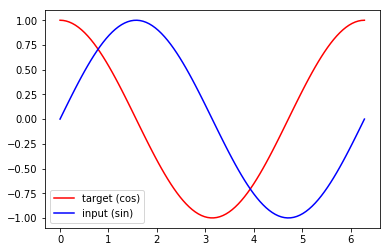

In [5]:
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)
x_np = np.sin(steps)    # float32 for converting torch FloatTensor
y_np = np.cos(steps)
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

In [6]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # number of rnn layer
            batch_first=True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)
        #print("r_out.shape",r_out.shape)
        #print("r_out",r_out)

        outs = []    # save all predictions
        for time_step in range(r_out.size(1)):    # calculate output for each time step
            outs.append(self.out(r_out[:, time_step, :]))
            #print(outs)
            #print("outs.shape",np.asarray(outs).shape)
            
        
        return torch.stack(outs, dim=1), h_state
        

rnn = RNN()
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [8]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all rnn parameters
loss_func = nn.MSELoss()

In [9]:
h_state = None      # for initial hidden state

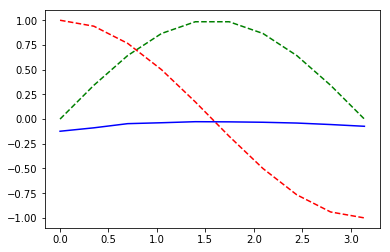

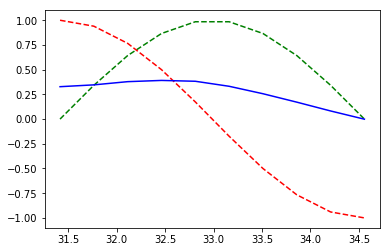

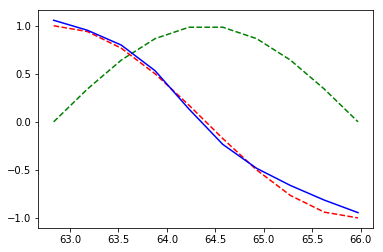

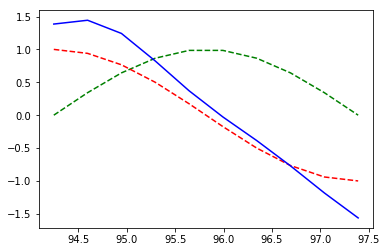

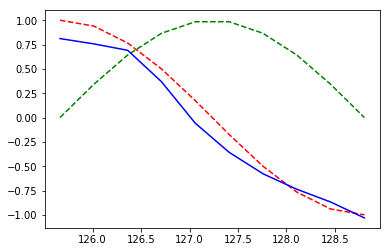

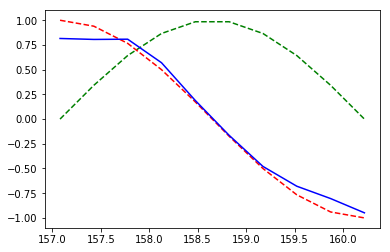

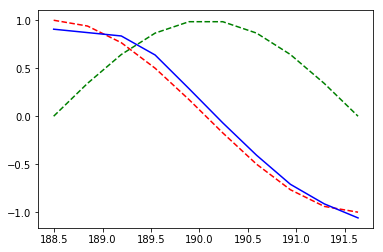

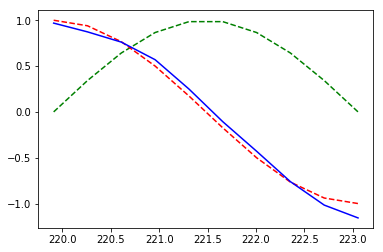

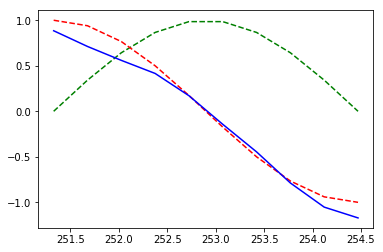

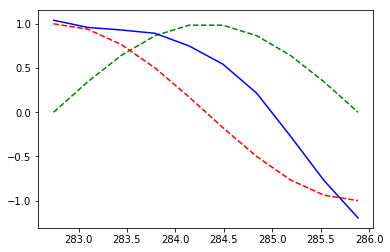

In [10]:
for step in range(100):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps)    # float32 for converting torch FloatTensor
    y_np = np.cos(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])    # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])

    prediction, h_state = rnn(x, h_state)   # rnn output
    #print(prediction)
    # !! next step is important !!
    h_state = h_state.data        # repack the hidden state, break the connection from last iteration

    loss = loss_func(prediction, y)         # calculate loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

    # plotting
    if step % 10 == 0:
        plt.plot(steps, x_np.flatten(), 'g--')
        plt.plot(steps, y_np.flatten(), 'r--')
        plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
        plt.draw()
        plt.show()

In [ ]:
loss